In [1]:
import numpy as np

x = np.array([ 0,  3,  9, 14, 15, 19, 20, 21, 30, 35,
              40, 41, 42, 43, 54, 56, 67, 69, 72, 88])
y = np.array([33, 68, 34, 34, 37, 71, 37, 44, 48, 49,
              53, 49, 50, 48, 56, 60, 61, 63, 44, 71])

e = np.array([ 3.6, 3.9, 2.6, 3.4, 3.8, 3.8, 2.2, 2.1, 2.3, 3.8,
               2.2, 2.8, 3.9, 3.1, 3.4, 2.6, 3.4, 3.7, 2.0, 3.5])

ex=np.array([ 0.4,  0.1,  0.4,  0.4,  0.2,  0.2,  0.2,  0.1,  0.3,  0.2,  0.2,
        0.2,  0.1,  0.1,  0.4,  0.4,  0.4,  0.3,  0. ,  0.5])

In [48]:
len(x)

20

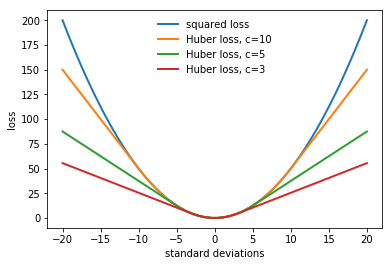

In [11]:
from scipy import optimize
import matplotlib.pyplot as plt

def squared_loss(theta, x=x, y=y, e=e):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / e) ** 2)

t = np.linspace(-20, 20)
def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

plt.plot(t, 0.5 * t ** 2, label="squared loss", lw=2)
for c in (10, 5, 3):
    plt.plot(t, huber_loss(t, c), label="Huber loss, c={0}".format(c), lw=2)
plt.ylabel('loss')
plt.xlabel('standard deviations')
plt.legend(loc='best', frameon=False);
plt.show()

def total_huber_loss(theta, x=x, y=y, e=e, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / e, c).sum()









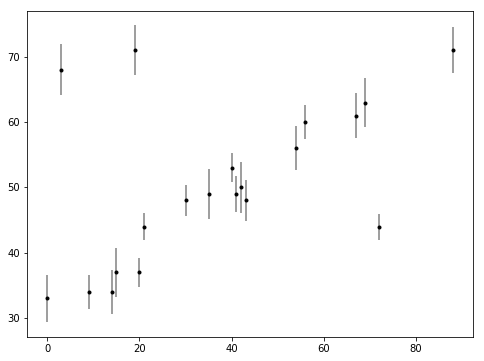

In [16]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(8,6)
plt.errorbar(x, y,e, fmt='.k', ecolor='gray');

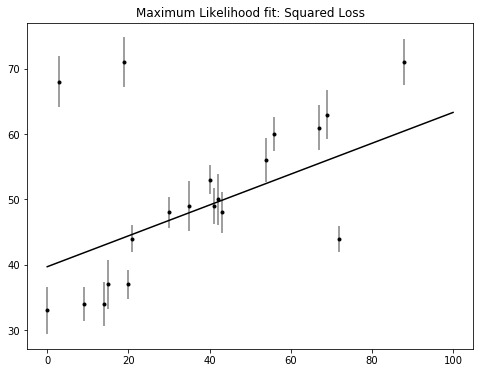

In [13]:
theta1 = optimize.fmin(squared_loss, [0, 0], disp=False)
xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, '-k')
plt.title('Maximum Likelihood fit: Squared Loss') 

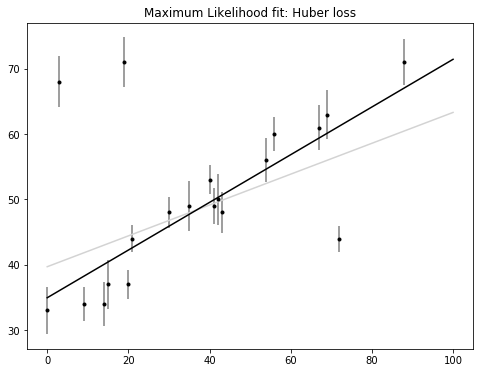

In [14]:
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='black')
plt.title('Maximum Likelihood fit: Huber loss');

In [15]:
def log_prior(theta):
    #g_i needs to be between 0 and 1
    if (all(theta[2:] > 0) and all(theta[2:] < 1)):
        return 0
    else:
        return -np.inf  # recall log(0) = -inf

def log_likelihood(theta, x, y, e, sigma_B):
    dy = y - theta[0] - theta[1] * x
    g = np.clip(theta[2:], 0, 1)  # g<0 or g>1 leads to NaNs in logarithm
    logL1 = np.log(g) - 0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2
    logL2 = np.log(1 - g) - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2
    return np.sum(np.logaddexp(logL1, logL2))

def log_posterior(theta, x, y, e, sigma_B):
    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B)



# theta will be an array of length 2 + N, where N is the number of points
# theta[0] is the intercept, theta[1] is the slope,
# and theta[2 + i] is the weight g_i



# Note that this step will take a few minutes to run!

ndim = 2 + len(x)  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 10000  # "burn-in" period to let chains stabilize
nsteps = 15000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta1, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, e, 50])
#sigma_B a nuisance parameter or its value can be set at a sufficiently high number, say 50

sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
print(sample.shape)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
print(sample.shape)



/Users/brettlv/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/Users/brettlv/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


(50, 15000, 22)
(250000, 22)


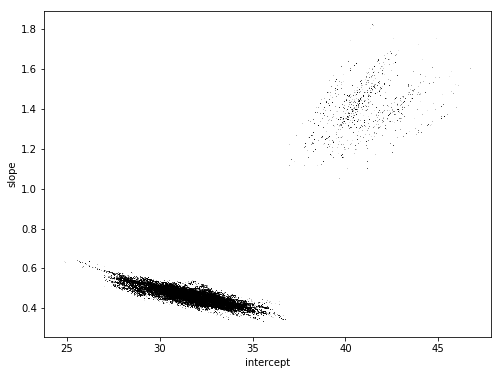

In [17]:
plt.plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
plt.xlabel('intercept')
plt.ylabel('slope');

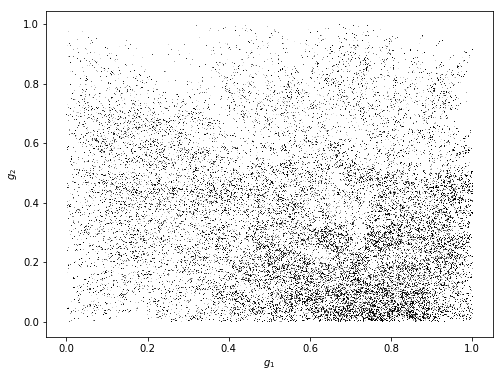

In [18]:
plt.plot(sample[:, 2], sample[:, 3], ',k', alpha=0.1)
plt.xlabel('$g_1$')
plt.ylabel('$g_2$')

g1 mean: 0.60
g2 mean: 0.32
g3 mean: 0.63
g4 mean: 0.63


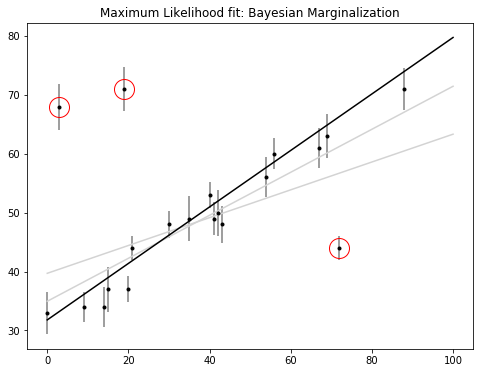

In [19]:
print("g1 mean: {0:.2f}".format(sample[:, 2].mean()))
print("g2 mean: {0:.2f}".format(sample[:, 3].mean()))
print("g3 mean: {0:.2f}".format(sample[:, 4].mean()))
print("g4 mean: {0:.2f}".format(sample[:, 5].mean()))

theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
outliers = (g < 0.5)
xfit = np.linspace(0, 100)
plt.errorbar(x, y, e, fmt='.k', ecolor='gray')
plt.plot(xfit, theta1[0] + theta1[1] * xfit, color='lightgray')
plt.plot(xfit, theta2[0] + theta2[1] * xfit, color='lightgray')
plt.plot(xfit, theta3[0] + theta3[1] * xfit, color='black')
plt.plot(x[outliers], y[outliers], 'ro', ms=20, mfc='none', mec='red')
plt.title('Maximum Likelihood fit: Bayesian Marginalization');

/Users/brettlv/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


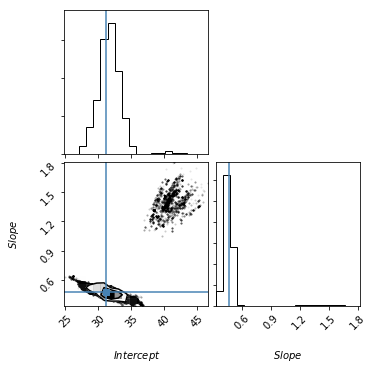

In [31]:
import corner
#intercept=sample[:,0]
#slope=sample[:,1]
fig = corner.corner(sample[:,:2], labels=["$Intercept$", "$Slope$",],
                      truths=[31.25, 0.47])
fig.show()

31.2509442569 0.471414547129


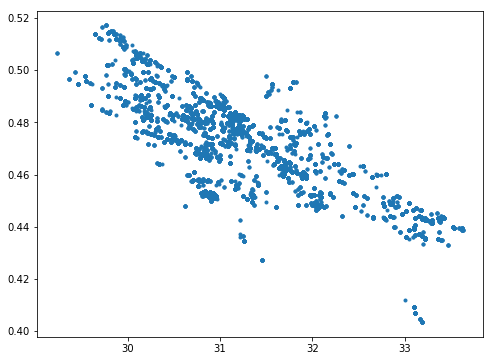

In [30]:
intercept_=np.mean(sample[-10000:, 0])
slope_=np.mean(sample[-10000:, 1])
print(intercept_,slope_)
plt.plot(sample[-10000:, 0],sample[-10000:, 1],'.')


In [43]:
intercept_var,slope_var=map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(sample[-10000:,:2], [16, 50, 84],
                                                axis=0)))

print(intercept_var)
print(slope_var)

(31.114600518966846, 0.93801412221521474, 0.68830882474447463)
(0.47390814941540271, 0.01401376454654657, 0.021900415832775577)


In [47]:
a=np.array([1,2,3])
b=np.array([1,2,3])
a*b,np.dot(a,b)

(array([1, 4, 9]), 14)

In [21]:
import numpy as np
for a in np.linspace(1.8,2.2,100):
    for b in np.linspace(0.8,1.2,100):
        for c in np.linspace(0.8,1.2,100):
            for d in np.linspace(0.8,1.2,100):
                sum=150000*a+360000*b+200000*c+160000*d
                if abs(sum-1015430)<10:
                    print(a,b,c,d)